In [1]:
import pandas as pandas
import math
import numpy as np
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sklearn

In [2]:
#get data from github
url = "https://github.com/tjzuech/ml-project/raw/main/data.csv.zip"
data = pandas.read_csv(url)

In [3]:
#visulaize the data
#data.head(10)

In [4]:
#create a Home or Away Flag via the an @ or vs in the matchup feature
data.loc[data.matchup.str.find("@") >= 0, "home_flag"] = "0"
data.loc[data.matchup.str.find("vs") >= 0, "home_flag"] = "1"
#data.location.value_counts()

In [5]:
#create a running time column
time = []
for i in range(0,len(data.period)):
  minutes = data.period.iloc[i] * 12 - data.minutes_remaining.iloc[i] #calculate running minutes based on period and minutes remaining
  seconds = 60 - data.seconds_remaining.iloc[i] #calculate running seconds based on seconds remaining
  seconds = seconds / 60 #make seconds as a fraction of a minute
  if seconds == 1: # if the time is 60 seconds remaining, do not add a full minute
    seconds = 0
  time.append(minutes - seconds)
data["time"] = time


In [6]:
#drop unnecessary columns
data = data.drop(columns = ["minutes_remaining","period","seconds_remaining", "shot_zone_basic","shot_zone_area","team_name","team_id","matchup","shot_zone_range","combined_shot_type","game_id","lat","lon"])
#data.head(10)

home_flag
0    0.436421
1    0.456468
Name: shot_made_flag, dtype: float64
action_type
Turnaround Finger Roll Shot           1.000000
Hook Bank Shot                        1.000000
Driving Floating Bank Jump Shot       1.000000
Running Slam Dunk Shot                1.000000
Reverse Slam Dunk Shot                1.000000
Slam Dunk Shot                        0.982036
Driving Slam Dunk Shot                0.976744
Driving Dunk Shot                     0.976654
Alley Oop Dunk Shot                   0.947368
Reverse Dunk Shot                     0.918033
Follow Up Dunk Shot                   0.900000
Fadeaway Bank shot                    0.888889
Running Dunk Shot                     0.888889
Driving Finger Roll Layup Shot        0.881356
Running Hook Shot                     0.878788
Driving Finger Roll Shot              0.852941
Running Bank shot                     0.837209
Finger Roll Layup Shot                0.821429
Turnaround Bank shot                  0.793103
Dunk Shot           

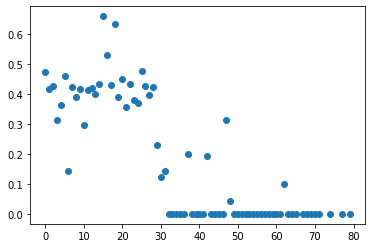

In [7]:
#data visualization
#shots made at home/away percentage
made = data.groupby("home_flag")["shot_made_flag"].sum()
total = data.groupby("home_flag")["shot_made_flag"].count()
locationPercentage = made/total
print(locationPercentage)

#shot type percentage
made_by_shot = data.groupby("action_type")["shot_made_flag"].sum()
total_by_shot = data.groupby("action_type")["shot_made_flag"].count()
made_by_shot.sort_values(ascending = False)
total_by_shot.sort_values(ascending = False)
shotPercentage = made_by_shot/total_by_shot
shotPercentage = shotPercentage.sort_values(ascending = False)
print(shotPercentage)

#shot percentage based off distance
made_by_distance = data.groupby("shot_distance")["shot_made_flag"].sum()
total_by_distance = data.groupby("shot_distance")["shot_made_flag"].count()
distancePercentage = made_by_distance/total_by_distance
x = data.shot_distance.unique()
y = distancePercentage

plt.scatter(x,y)


In [8]:
#create more accurate shot distance
#this runs after the data visualization
data = data.drop(columns = "shot_distance")
distance = []
for i in range(0,len(data.loc_x)):
  shot_distance = math.sqrt(data.loc_x.iloc[i] ** 2 + data.loc_y.iloc[i] ** 2) #shot distance based on right triangle to hoop
  distance.append(shot_distance)
data["shot_distance"] = distance

In [9]:
#convert string to categorical data
categories = []
categories = ["action_type","season","shot_type","opponent"]

for i in range(0,len(categories),1):
  data[categories[i]] = data[categories[i]].astype('category') #convert to categories
  data[categories[i]] = data[categories[i]].cat.codes #use category numbers


In [10]:
#convert game date to integer date
import datetime
from datetime import datetime
from pandas import Timestamp
date_as_int = []

for i in range(0,len(data.game_date)):
    date = data.game_date.iloc[i]
    values = date.split("-") #split the year, month, and day
    date_as_int.append(1000*(int(values[0]))+ 10* int(values[1]) + int(values[2])) #1000*year + 10*month + day

data["date_as_int"] = date_as_int
data = data.drop(columns = "game_date")


In [11]:
#import models

from sklearn.model_selection import train_test_split


#classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
#estimators
from sklearn.linear_model import LinearRegression

from sklearn import metrics

In [12]:
#drop NaN values from shot made flag
testdata = data[data.shot_made_flag.isna()]
data = data.dropna()
#testdata.head()

In [13]:
#create training/testing data for analyzing the model
#x = data.drop(columns = "shot_made_flag")
#y = data["shot_made_flag"]

#train_x, test_x, train_y, test_y = train_test_split(x, y, train_size = .83, test_size = .17, random_state = 99)

In [14]:
#create finalized testing data
#only uncomment once done with final iterations
train_x = data.drop(columns = "shot_made_flag")
train_y = data["shot_made_flag"]
test_x = testdata.drop(columns = "shot_made_flag")
test_y = testdata["shot_made_flag"]
#test_x.head

In [34]:
#feature selection on finished features
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
selector = SelectKBest(f_classif,k = 13).fit(train_x,train_y)





mask = selector.get_support() #list of booleans
kept_features = [] # The list of your K best features

old_features = list(train_x.columns.values)
for bool, feature in zip(mask, old_features):
    if bool:
        kept_features.append(feature)
kept_features


feature_scores = pandas.DataFrame(list(zip(kept_features,selector.scores_)),columns = ("feature","f_score"))
feature_scores = feature_scores.sort_values("f_score",ascending = False)
print(feature_scores)
#train_x = train_x.drop(columns = features_dropped)
#test_x = test_x.drop(columns = features_dropped)


#pca = PCA(n_components = 13)
#pca.fit(train_x,train_y)
#pca.explained_variance_

          feature      f_score
11  shot_distance  1060.591514
3           loc_y   575.986903
6       shot_type   384.756732
10           time    36.334152
1   game_event_id    35.667636
9       home_flag    10.442676
5          season     9.062537
12    date_as_int     8.968471
8         shot_id     4.353629
7        opponent     1.816573
0     action_type     0.187776
4        playoffs     0.040593
2           loc_x     0.018457


In [16]:
#test models

#run to use all classifiers
classifiers = [KNeighborsClassifier(),GaussianNB(),DecisionTreeClassifier(),AdaBoostClassifier(),QuadraticDiscriminantAnalysis(),LogisticRegression(),RandomForestClassifier(n_estimators = 50)]
for classifier in classifiers:
  classifier = classifier
  classifier.fit(train_x,train_y)
  train_y_pred = classifier.predict_proba(train_x) #train predicted values
  test_y_pred = classifier.predict_proba(test_x) #test predicted values
  train_log_loss = metrics.log_loss(train_y,train_y_pred) # log_loss
#  test_log_loss = metrics.log_loss(test_y,test_y_pred) #log_loss
  
#  print("\n\n",classifier)
#  print("Train Log_Loss" , train_log_loss)
#  print("Test Log_Loss",test_log_loss)

#run to use all estimators  
estimators = [LinearRegression()]
for estimator in estimators:
  estimator = estimator
  estimator.fit(train_x,train_y)
  train_y_pred = estimator.predict(train_x) #train predicted values
  test_y_pred = estimator.predict(test_x) #test predicted values
  train_log_loss = metrics.log_loss(train_y,train_y_pred) #log_loss
#  test_log_loss = metrics.log_loss(test_y,test_y_pred) #log_loss
#  print("\n\n",estimator)
#  print("Train Log_Loss" , train_log_loss)
#  print("Test Log_Loss",test_log_loss)

In [17]:
#run final model
classifier = RandomForestClassifier(n_estimators = 1000,min_samples_leaf = 2,min_samples_split = 4)
classifier.fit(train_x,train_y)
train_y_pred = classifier.predict_proba(train_x)
test_y_pred = classifier.predict_proba(test_x)

In [18]:
#create submission
submission = pandas.DataFrame()
shot_id = []
shot_made_flag = []
for i in range(len(test_x.shot_id)):
  shot_id.append(test_x.shot_id.iloc[i]) # fill the shot_id array
  shot_made_flag.append(test_y_pred[i,1]) # fill the shot_made_flag array
submission["shot_id"] = shot_id
submission["shot_made_flag"] = shot_made_flag

submission.to_csv('submission.csv', index=False) # create the submission file

